# Privacy-Utility Tradeoff Analysis (Folktables Data-Point)

This notebook runs a series of experiments to compare the privacy-utility tradeoff for two different federated k-means initialization methods on the **Folktables Data-Point Privacy** scenario.

We will test two scenarios over a range of privacy budgets (epsilon):

1.  **Scenario 1: `initialization_algorithm: KFed` (Non-Private Init)**
    * This uses a **non-private** initialization method (`KFed`).
    * Privacy is **only** applied during the `FederatedLloyds` clustering steps.
    * We will set `fedlloyds_epsilon` to our target `E` and plot against the final **printed epsilon** for the "Clustering" phase.

2.  **Scenario 2: `initialization_algorithm: FederatedClusterInitExact` (Private Init)**
    * This uses the paper's novel **private** initialization method (`FedDP-Init`).
    * Following the paper's findings (Table 4), we will set **`fedlloyds_num_iterations: 0`**.
    * We will split the total target epsilon `E` across the **three** initialization steps (`E/3` each).
    * We will plot against the final, **printed epsilon** for the "Initialization" phase.

**Metrics:**
* **Utility (Y-axis):** K-Means Cost (lower is better) and Clustering Accuracy (higher is better).
* **Privacy (X-axis):** Final Composed Epsilon (lower is better).

In [1]:
import os
import sys
import subprocess
import yaml
import re
import pickle
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Setup & Configuration ---

# Add project root to path and change CWD
PROJECT_ROOT = ".."
notebook_dir = os.path.abspath('')
project_root_path = os.path.abspath(os.path.join(notebook_dir, PROJECT_ROOT))

if project_root_path not in sys.path:
    print(f"Adding {project_root_path} to system path.")
    sys.path.insert(0, project_root_path)

if os.getcwd() != project_root_path:
    print(f"Changing CWD from {os.getcwd()} to {project_root_path}")
    os.chdir(project_root_path)
else:
    print(f"Already in correct CWD: {os.getcwd()}")

# --- Global Settings ---
BASE_CONFIG_PATH = 'configs/folktables.yaml'

# --- !!! --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# --- TO RUN THE FULL SCRIPT, UNCOMMENT THE "FULL" LINE AND COMMENT THE "TEST" LINE ---
# EPSILON_VALUES_TEST = [0.25, 1.0] # Quick test run (2 values)
EPSILON_VALUES_FULL = np.arange(0.25, 2.26, 0.25).tolist() # Full run [0.25, 0.5, ..., 2.25]

# EPSILON_TARGET_RANGE = EPSILON_VALUES_TEST
EPSILON_TARGET_RANGE = EPSILON_VALUES_FULL # <-- UNCOMMENT THIS LINE FOR THE FULL RUN
# --- !!! --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

RESULTS_DIR = 'results/data_point_level/folktables'
RESULTS_PKL_PATH = os.path.join(RESULTS_DIR, 'summary_results.pkl')
TEMP_CONFIG_DIR = 'paper_scripts' # Save temp configs here
SEED = 42

print(f"Base Config: {BASE_CONFIG_PATH}")
print(f"Epsilon Target Range: {EPSILON_TARGET_RANGE}")
print(f"Results Path: {RESULTS_PKL_PATH}")
print(f"CWD: {os.getcwd()}")

Adding /home/urvi/maml_project/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main to system path.
Changing CWD from /home/urvi/maml_project/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main/paper_scripts to /home/urvi/maml_project/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main
Base Config: configs/folktables.yaml
Epsilon Target Range: [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
Results Path: results/data_point_level/folktables/summary_results.pkl
CWD: /home/urvi/maml_project/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main


In [2]:
# --- 2. Helper Functions (Unchanged) ---

def create_temp_config(base_config, overrides, path):
    """Creates a temporary YAML config file with specified overrides."""
    config = base_config.copy()
    config.update(overrides)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        yaml.dump(config, f)
    print(f"Created temp config: {path}")

def run_experiment(config_path):
    """Runs run.py with the given config (from project root) and returns stdout."""
    cmd = ['python', 'run.py', '--args_config', config_path, '--seed', str(SEED)]
    print(f"\n---> Running command: {' '.join(cmd)}")
    
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True, encoding='utf-8')
        print(result.stdout)
        if result.stderr:
            print("--- STDERR ---")
            print(result.stderr)
        return result.stdout
    except subprocess.CalledProcessError as e:
        print(f"--- ERROR running experiment --- (returncode {e.returncode})")
        print("--- STDOUT ---")
        print(e.stdout)
        print("--- STDERR ---")
        print(e.stderr)
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def parse_output_and_results(stdout, pkl_path):
    """
    Parses the final epsilon/delta from stdout and loads cost/accuracy from the pkl file.
    """
    final_epsilon = np.nan
    final_delta = np.nan
    cost = np.nan
    accuracy = np.nan
    
    try:
        pattern_clustering = re.compile(r"Clustering is \(([\d\.]+), ([\de\-\+]+)\)-DP")
        pattern_init = re.compile(r"Initialization is \(([\d\.]+), ([\de\-\+]+)\)-DP")
        
        matches_clustering = pattern_clustering.findall(stdout)
        matches_init = pattern_init.findall(stdout)

        if matches_clustering:
            final_epsilon = float(matches_clustering[-1][0])
            final_delta = float(matches_clustering[-1][1])
            print(f"Parsed Epsilon (from Clustering): {final_epsilon}, Parsed Delta: {final_delta}")
        elif matches_init:
            final_epsilon = float(matches_init[-1][0])
            final_delta = float(matches_init[-1][1])
            print(f"Parsed Epsilon (from Init): {final_epsilon}, Parsed Delta: {final_delta}")
        else:
            print("Warning: Could not parse epsilon/delta from stdout.")
    except Exception as e:
        print(f"Error parsing epsilon/delta: {e}")

    try:
        with open(pkl_path, 'rb') as f:
            results_dict = pickle.load(f)
        
        final_key = 'Clustering' if 'Clustering' in results_dict else 'Initialization'
        if final_key in results_dict:
            cost = results_dict[final_key].get('Train client cost', np.nan)
            accuracy = results_dict[final_key].get('Train client accuracy', np.nan)
            print(f"Loaded Cost: {cost}, Accuracy: {accuracy} (from '{final_key}')")
        else:
            print(f"Warning: '{final_key}' key not in {pkl_path}.")
            
    except FileNotFoundError:
        print(f"Error: Results file not found at {pkl_path}")
    except Exception as e:
        print(f"Error loading pkl file: {e}")
        
    return final_epsilon, final_delta, cost, accuracy

print("Helper functions defined.")

Helper functions defined.


In [3]:
# --- 3. Experiment Runner ---
# This cell will take a long time to run!

kfed_res_perm = []
feddp_res_perm = []

def run_all_experiments():
    """
    Main function to run both KFed and FedDP-Init scenarios.
    """
    global kfed_res_perm
    global feddp_res_perm
    try:
        with open(BASE_CONFIG_PATH, 'r') as f:
            base_config = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"ERROR: Base config file not found at {BASE_CONFIG_PATH}")
        return None, None
    except Exception as e:
        print(f"Error loading base config: {e}")
        return None, None

    # --- Scenario 1: KFed (Non-Private Init) ---
    print("="*50)
    print("STARTING SCENARIO 1: KFed (Non-Private Init)")
    print("="*50)
    kfed_results = []
    temp_config_path = os.path.join(TEMP_CONFIG_DIR, 'temp_kfed_config.yaml') 
    
    for target_eps in EPSILON_TARGET_RANGE:
        print(f"\n--- KFed: Target Epsilon = {target_eps} ---")
        overrides = {
            'initialization_algorithm': 'KFed',
            'fedlloyds_epsilon': target_eps, # Only change this epsilon
            'outer_product_epsilon': 1.0,
            'weighting_epsilon': 1.0,
            'center_init_gaussian_epsilon': 1.0,
            'fedlloyds_num_iterations': 1 # Run 1 Lloyd's iteration
        }
        
        create_temp_config(base_config, overrides, temp_config_path)
        stdout = run_experiment(temp_config_path)
        
        if stdout is not None:
            epsilon, delta, cost, acc = parse_output_and_results(stdout, RESULTS_PKL_PATH)
            kfed_results.append({'target_epsilon': target_eps, 'final_epsilon': epsilon, 'delta': delta, 'cost': cost, 'accuracy': acc})
        
    df_kfed = pd.DataFrame(kfed_results).dropna().sort_values(by='final_epsilon')
    

    # --- Scenario 2: FederatedClusterInitExact (Private Init) --- 
    print("="*50)
    print("STARTING SCENARIO 2: FedDP-Init (Private Init)")
    print("="*50)
    feddp_results = []
    temp_config_path = os.path.join(TEMP_CONFIG_DIR, 'temp_feddp_config.yaml')

    for target_eps in EPSILON_TARGET_RANGE:
        print(f"\n--- FedDP-Init: Target Epsilon = {target_eps} ---")
        # Split budget over 3 init steps (since lloyds_num_iterations will be 0)
        eps_per_step = target_eps / 3.0 
        print(f"    (Setting each of 3 init epsilons to {eps_per_step:.4f})")
        overrides = {
            'initialization_algorithm': 'FederatedClusterInitExact',
            'outer_product_epsilon': eps_per_step,
            'weighting_epsilon': eps_per_step,
            'center_init_gaussian_epsilon': eps_per_step,
            'fedlloyds_epsilon': 1.0, # Default value, won't be used
            # Folktables config file already sets iterations to 1.
            # We will override it to 0 based on paper's findings (Table 4)
            'fedlloyds_num_iterations': 0 
        }
        
        create_temp_config(base_config, overrides, temp_config_path)
        stdout = run_experiment(temp_config_path)
        
        if stdout is not None:
            # The final cost will be from the "Initialization" step
            epsilon, delta, cost, acc = parse_output_and_results(stdout, RESULTS_PKL_PATH)
            feddp_results.append({'target_epsilon': target_eps, 'final_epsilon': epsilon, 'delta': delta, 'cost': cost, 'accuracy': acc})

    df_feddp = pd.DataFrame(feddp_results).dropna().sort_values(by='final_epsilon')
    kfed_res_perm = df_kfed
    feddp_res_perm = df_feddp
    # --- Print Final Tables ---
    print("\n" + "="*50)
    print("--- KFed (Non-Private Init) Results Table ---")
    print("="*50)
    print(df_kfed.to_markdown(index=False, floatfmt=".4f"))
    
    print("\n" + "="*50)
    print("--- FedDP-Init (Private Init) Results Table ---")
    print("="*50)
    print(df_feddp.to_markdown(index=False, floatfmt=".4f"))

    return df_kfed, df_feddp

# --- Run the main experiment block ---
df_kfed, df_feddp = run_all_experiments()

STARTING SCENARIO 1: KFed (Non-Private Init)

--- KFed: Target Epsilon = 0.25 ---
Created temp config: paper_scripts/temp_kfed_config.yaml

---> Running command: python run.py --args_config paper_scripts/temp_kfed_config.yaml --seed 42
Final Server Dataset Size: 1020 samples
Metrics at iteration 0 ():
    Train population | number of devices              : 51
    Train population | number of data points          : 2499.823529411765
    Train population | total weight                   : 1.0
    Number of parameters                              : 417690

Evaluating Initialization...
Train Cost 3.5811, Train Accuracy 0.6565
Val Cost 3.5534, Val Accuracy 0.6388

Initialization is (0, 1e-06)-DP


#########
Running Clustering
#########

Metrics at iteration 0 ():
    Train population | number of devices              : 51
    Train population | number of data points          : 2499.823529411765
    Train population | kmeans-cost                    : 3.581087879283873
    Train population | k

In [4]:
print("\n" + "="*50)
print("--- KFed (Non-Private Init) Results Table ---")
print("="*50)
print(df_kfed.to_markdown(index=False, floatfmt=".4f"))

print("\n" + "="*50)
print("--- FedDP-Init (Private Init) Results Table ---")
print("="*50)
print(df_feddp.to_markdown(index=False, floatfmt=".4f"))



--- KFed (Non-Private Init) Results Table ---
|   target_epsilon |   final_epsilon |   delta |   cost |   accuracy |
|-----------------:|----------------:|--------:|-------:|-----------:|
|           0.2500 |          0.2442 |  0.0000 | 3.5699 |     0.6574 |
|           0.5000 |          0.4894 |  0.0000 | 3.5375 |     0.6574 |
|           0.7500 |          0.7349 |  0.0000 | 3.5307 |     0.6575 |
|           1.0000 |          0.9805 |  0.0000 | 3.5281 |     0.6575 |
|           1.2500 |          1.2263 |  0.0000 | 3.5269 |     0.6575 |
|           1.5000 |          1.4723 |  0.0000 | 3.5263 |     0.6575 |
|           1.7500 |          1.7183 |  0.0000 | 3.5258 |     0.6575 |
|           2.0000 |          1.9645 |  0.0000 | 3.5256 |     0.6575 |
|           2.2500 |          2.2108 |  0.0000 | 3.5254 |     0.6575 |

--- FedDP-Init (Private Init) Results Table ---
|   target_epsilon |   final_epsilon |   delta |   cost |   accuracy |
|-----------------:|----------------:|--------:|----

--- 
## 4. Results: 2x2 Plot Grid (Separate Plots)

Here are the four separate plots you requested, showing the privacy-utility tradeoff for each scenario and metric independently.


Generating 2x2 Plots...


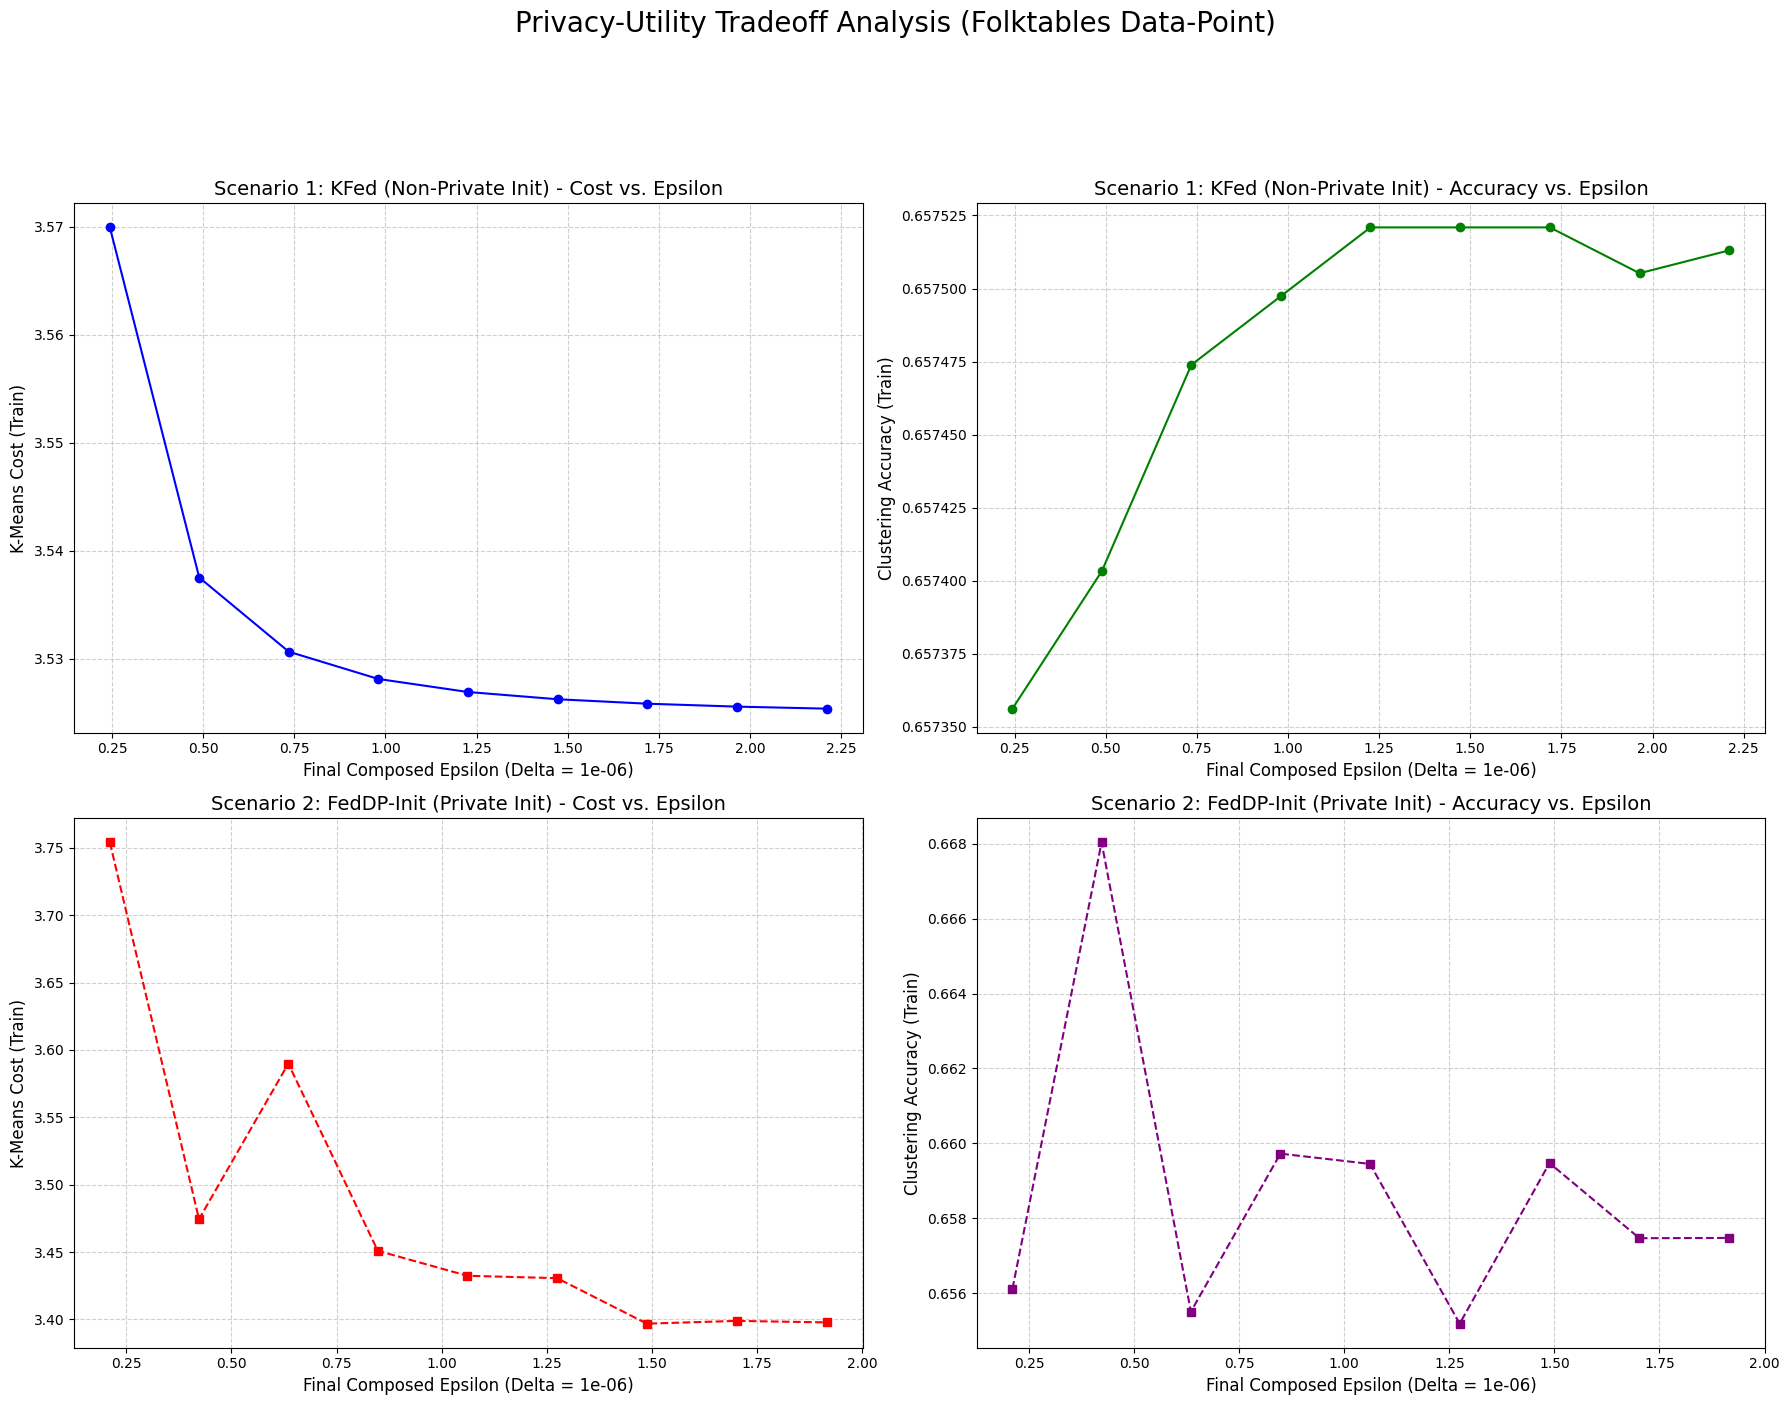

In [5]:
def plot_2x2_grid(df_kfed, df_feddp):
    """
    Generates the 2x2 plot grid as requested.
    """
    print("\nGenerating 2x2 Plots...")
    if df_kfed.empty and df_feddp.empty:
        print("DataFrames are empty. Skipping 2x2 plot.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Privacy-Utility Tradeoff Analysis (Folktables Data-Point)', fontsize=20, y=1.03)
    
    # --- KFed Plots ---
    ax1 = axes[0, 0]
    if not df_kfed.empty:
        ax1.plot(df_kfed['final_epsilon'], df_kfed['cost'], marker='o', linestyle='-', color='blue')
        ax1.set_title('Scenario 1: KFed (Non-Private Init) - Cost vs. Epsilon', fontsize=14)
    else:
        ax1.set_title('Scenario 1: KFed (Non-Private Init) - No Data', fontsize=14)
    ax1.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax1.set_ylabel('K-Means Cost (Train)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = axes[0, 1]
    if not df_kfed.empty:
        ax2.plot(df_kfed['final_epsilon'], df_kfed['accuracy'], marker='o', linestyle='-', color='green')
        ax2.set_title('Scenario 1: KFed (Non-Private Init) - Accuracy vs. Epsilon', fontsize=14)
    else:
        ax2.set_title('Scenario 1: KFed (Non-Private Init) - No Data', fontsize=14)
    ax2.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax2.set_ylabel('Clustering Accuracy (Train)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)

    # --- FedDP-Init Plots ---
    ax3 = axes[1, 0]
    if not df_feddp.empty:
        ax3.plot(df_feddp['final_epsilon'], df_feddp['cost'], marker='s', linestyle='--', color='red')
        ax3.set_title('Scenario 2: FedDP-Init (Private Init) - Cost vs. Epsilon', fontsize=14)
    else:
        ax3.set_title('Scenario 2: FedDP-Init (Private Init) - No Data', fontsize=14)
    ax3.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax3.set_ylabel('K-Means Cost (Train)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.6)
    
    ax4 = axes[1, 1]
    if not df_feddp.empty:
        ax4.plot(df_feddp['final_epsilon'], df_feddp['accuracy'], marker='s', linestyle='--', color='purple')
        ax4.set_title('Scenario 2: FedDP-Init (Private Init) - Accuracy vs. Epsilon', fontsize=14)
    else:
        ax4.set_title('Scenario 2: FedDP-Init (Private Init) - No Data', fontsize=14)
    ax4.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax4.set_ylabel('Clustering Accuracy (Train)', fontsize=12)
    ax4.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if 'df_kfed' in locals() and 'df_feddp' in locals():
    plot_2x2_grid(df_kfed, df_feddp)
else:
    print("Experiment dataframes not found. Skipping 2x2 plot.")

--- 
## 5. Results: 1x2 Comparative Plots

These plots show both initialization methods on the same axes. This clearly demonstrates the tradeoff and the advantage of using a private initialization (`FedDP-Init`) over a non-private one (`KFed`).


Generating 1x2 Comparative Plots...


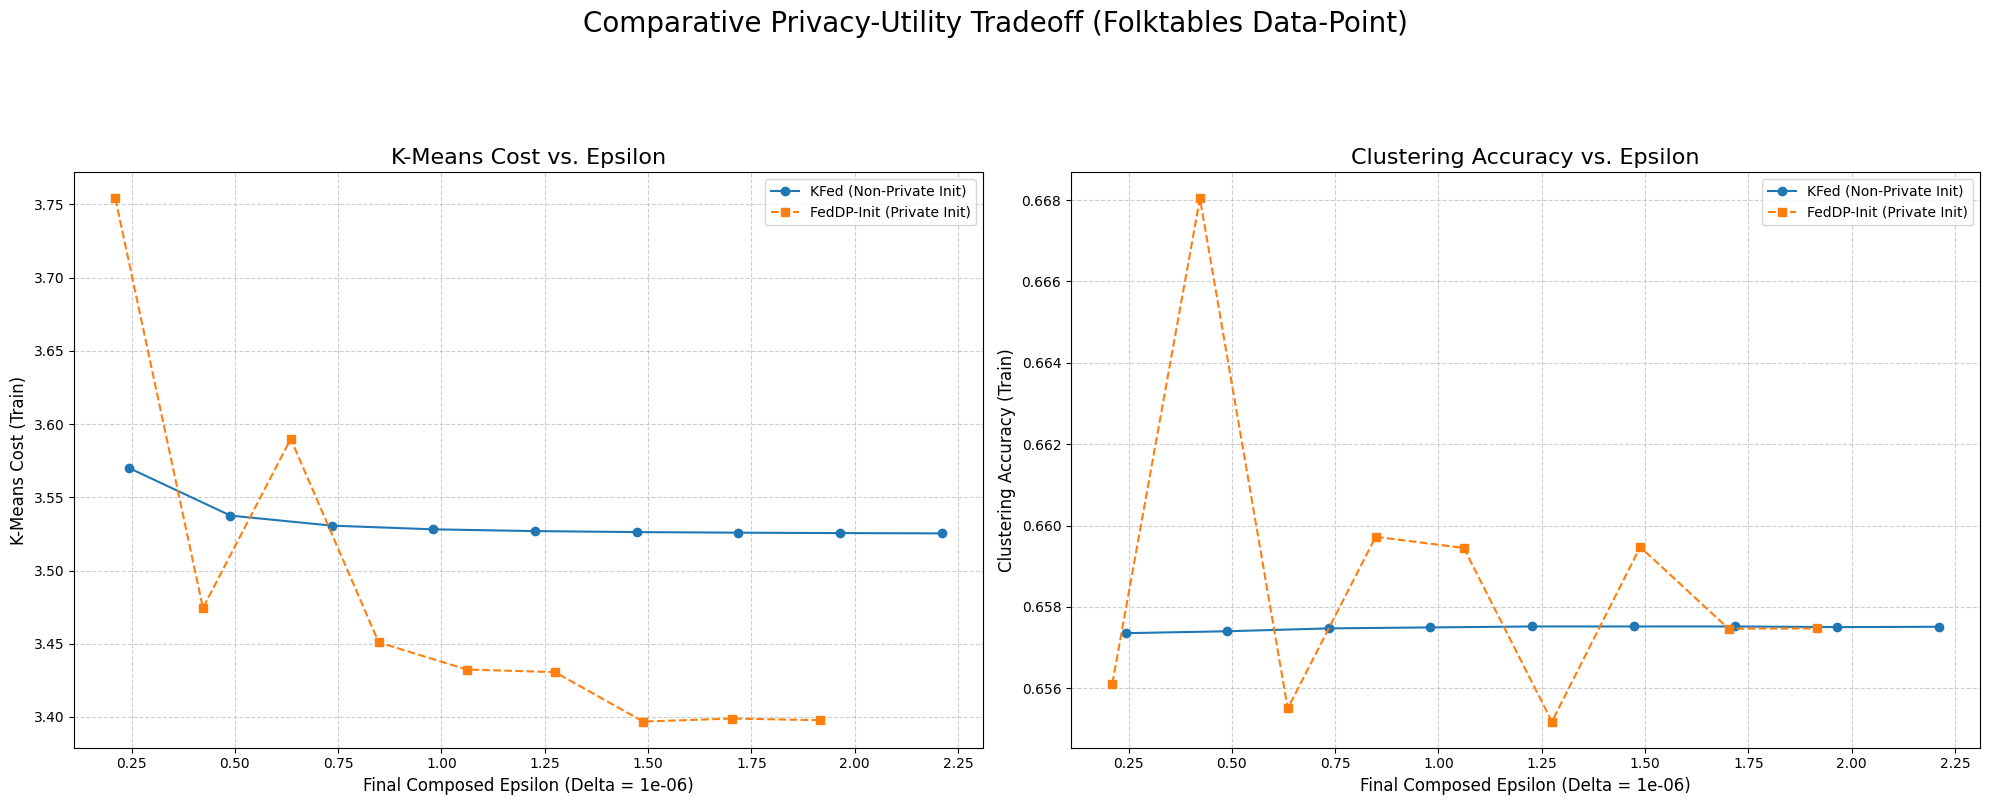

In [6]:
def plot_comparative_grid(df_kfed, df_feddp):
    """
    Generates a 1x2 comparative plot grid.
    """
    print("\nGenerating 1x2 Comparative Plots...")
    if df_kfed.empty and df_feddp.empty:
        print("DataFrames are empty. Skipping comparative plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Comparative Privacy-Utility Tradeoff (Folktables Data-Point)', fontsize=20, y=1.03)
    
    # --- Comparative Cost Plot ---
    ax1 = axes[0]
    if not df_kfed.empty:
        ax1.plot(df_kfed['final_epsilon'], df_kfed['cost'], marker='o', linestyle='-', label='KFed (Non-Private Init)')
    if not df_feddp.empty:
        ax1.plot(df_feddp['final_epsilon'], df_feddp['cost'], marker='s', linestyle='--', label='FedDP-Init (Private Init)')
    ax1.set_title('K-Means Cost vs. Epsilon', fontsize=16)
    ax1.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax1.set_ylabel('K-Means Cost (Train)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Comparative Accuracy Plot ---
    ax2 = axes[1]
    if not df_kfed.empty:
        ax2.plot(df_kfed['final_epsilon'], df_kfed['accuracy'], marker='o', linestyle='-', label='KFed (Non-Private Init)')
    if not df_feddp.empty:
        ax2.plot(df_feddp['final_epsilon'], df_feddp['accuracy'], marker='s', linestyle='--', label='FedDP-Init (Private Init)')
    ax2.set_title('Clustering Accuracy vs. Epsilon', fontsize=16)
    ax2.set_xlabel('Final Composed Epsilon (Delta = 1e-06)', fontsize=12)
    ax2.set_ylabel('Clustering Accuracy (Train)', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

if 'df_kfed' in locals() and 'df_feddp' in locals():
    plot_comparative_grid(df_kfed, df_feddp)
else:
    print("Experiment dataframes not found. Skipping comparative plot.")

--- 
## 6. Cleanup

This final cell removes all the temporary config files and the results directory created by the experiments.

In [7]:
def cleanup():
    """Removes all temporary configs and results."""
    print("\n--- Cleaning up temporary files ---")
    temp_files = [
        os.path.join(TEMP_CONFIG_DIR, 'temp_kfed_config.yaml'),
        os.path.join(TEMP_CONFIG_DIR, 'temp_feddp_config.yaml')
    ]
    for f in temp_files:
        if os.path.exists(f):
            os.remove(f)
            print(f"Removed {f}")
            
    # Remove the results directory created by run.py
    if os.path.exists(RESULTS_DIR):
        try:
            shutil.rmtree(RESULTS_DIR)
            print(f"Removed results directory: {RESULTS_DIR}")
        except Exception as e:
            print(f"Error removing results directory {RESULTS_DIR}: {e}")
    else:
        print(f"Results directory not found, no cleanup needed: {RESULTS_DIR}")
        
    print("Cleanup complete.")

cleanup()


--- Cleaning up temporary files ---
Removed paper_scripts/temp_kfed_config.yaml
Removed paper_scripts/temp_feddp_config.yaml
Removed results directory: results/data_point_level/folktables
Cleanup complete.
